# Tempearture vs Salinity Scatterplot, 100 KM Seaward of the Cook Ice Shelf Grounding Line - and calculating DEPTH

Data Sources:   
BMR:  
 - Richter, O., Gwyther, D. E., Galton-Fenzi, B. K., and Naughten, K. A.: The Whole Antarctic Ocean Model (WAOM v1.0): development and evaluation, Geosci. Model Dev., 15, 617–647, https://doi.org/10.5194/gmd-15-617-2022, 2022.

Grounding Line (2003):
 - Bindschadler, R., & Choi, H. (2011) "High-resolution Image-derived Grounding and Hydrostatic Lines for the Antarctic Ice Sheet" U.S. Antarctic Program (USAP) Data Center. doi: https://doi.org/10.7265/N56T0JK2.

Ice Front (2011):
 - Greene, C. A., A. S. Gardner, N.-J. Schlegel, and A. D. Fraser. 2024. MEaSUREs ITS_LIVE Antarctic
Annual 240 m Ice Sheet Extent Masks, 1997-2021, Version 1. [ice_mask]. Boulder,
Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center.
https://doi.org/10.5067/9ZFX84T5GI6D. [July 2025].

Neutral Density Software:
 - Jackett, David R., Trevor J. McDougall, 1997: A Neutral Density Variable for the World's Oceans. J. Phys. Oceanogr., 27, 237–263. doi: 10.1175/1520-0485(1997)0272.0.CO;2

GSW Software:
 - McDougall, T.J. and P.M. Barker, 2011: Getting started with TEOS-10 and the Gibbs Seawater (GSW) Oceanographic Toolbox, 28pp., SCOR/IAPSO WG127, ISBN 978-0-646-55621-5.

MATLAB Neutral Density Funtion Calculations:
 - Naomi Krauzig (2025). CT_AS_diagram_neutral_density (https://github.com/naomikrauzig/CT_AS_diagram_neutral_density), GitHub. Retrieved July, 2025..



## Calculating z_rho Depth:

In [4]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
from pyproj import Transformer
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from rasterio.transform import from_origin
from pyproj import CRS

In [5]:
# Variable definition:
ds = xr.open_dataset("WAOM_Variables_3031.nc")
s_rho = ds['s_rho'] # This is the sigma-level coordinates, found within the netCDF file
zice = ds['zice_3031'] # This is the ice thickness, found within the netCDF file
h = ds['h_3031'] # This is the bathymetry, found within the netCDF file

# The following variables are not defined within the netCDF file (ds).
Cs_r = s_rho   # Cs_r is the 'S-coordinate stretching curves at RHO-points' which range between 0 and -1.
hc = 20   # hc is the 'S-coordinate parameter, critical depth', with units of 'metres'.
zeta = 0   # zeta is the free surface height, in metres.
    # Note that changes in hc and zeta had little impact on the z_rho value; changes in both up to 200 units altered the z_rho depth by < 10 metres. 

In [6]:
# z_rho calculation, from Richter et al., 2022

hwater = ds.h_3031 -abs(ds.zice_3031)
Zo_rho = (hc * ds.s_rho + Cs_r * hwater) / (hc + hwater)
z_rho = zeta + (zeta + hwater) * Zo_rho -abs(ds.zice_3031)

In [7]:
# Saving the z_rho values as a geotiff

ds = xr.open_dataset("WAOM_Variables_3031.nc") # Used as a spatial reference to map this new z_rho depth geotiff.

# Extract z_rho and transpose to (depth, y, x)
z_rho_t = z_rho.transpose('s_rho', 'y', 'x').values  

x = ds['x'].values 
y = ds['y'].values  

xres = np.abs(x[1] - x[0])
yres = np.abs(y[1] - y[0])
xmin = x.min() - xres / 2
ymax = y.max() + yres / 2

transform = from_origin(xmin, ymax, xres, yres)

crs = CRS.from_epsg(3031)

output_path = "z_rho_3031.tif"
bands, height, width = z_rho_t.shape

with rasterio.open(output_path, 'w', driver='GTiff', height=height, width=width, count=bands, dtype=z_rho_t.dtype, crs=crs, transform=transform) as dst:
    for i in range(bands):
        dst.write(z_rho_t[i, :, :], i + 1)  


## Preparing the Inputs for the TS Scatterplot

In [9]:
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping
from pyproj import CRS
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

In [10]:
# These are the spatial bounds to which 100 km seaward of the grounding line of Cook Ice Shelf is approximated.
roi_xy = [
    (1120355.5661, -2015411.0479),
    (1191254.77122, -2126729.43488),
    (1080711.415954, -2197135.024480),
    (1009812.20812, -2085816.64209)
]
roi_polygon = Polygon(roi_xy)

with rasterio.open("z_rho_3031.tif") as src:
    out_image_z, out_transform_z = mask(src, [mapping(roi_polygon)], crop=True)
    z_rho_bands = out_image_z.shape[0]
    
    bbox = rasterio.transform.array_bounds(out_image_z.shape[1], out_image_z.shape[2], out_transform_z)
    ymin, ymax = bbox[1], bbox[3]
    xmin, xmax = bbox[0], bbox[2]

ds = xr.open_dataset("WAOM_Variables_3031.nc")
salinity = ds['salt_3031']  # shape: (depth, y, x)
temperature = ds['temp_3031']

salinity_crop = salinity.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
temperature_crop = temperature.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

salinity_array = salinity_crop.values
temperature_array = temperature_crop.values

### Quick spatial plotting to confirm that the ROI is correct:

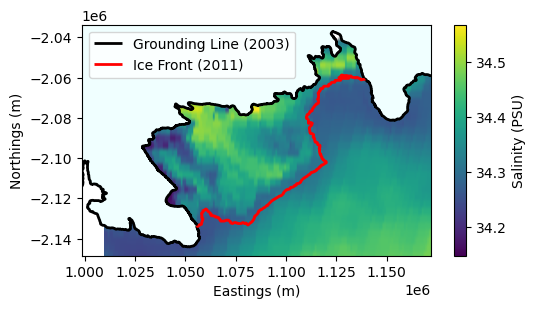

In [12]:
# Quick simple plot to verify that data is for the correct ROI:

verified_salt = salinity_crop[15] # can change this to temperature_crop or out_image_z to verify other variables
extent = [1009812.20812, 1191254.77122, -2197135.02448, -2015411.0479]
xlimit = (998648.2458, 1171935.9538)
ylimit = (-2148431.9935, -2033743.9935)

groundingline = gpd.read_file('2003_GL_full_cook_complete_dissolved_larger.shp')
coastline = gpd.read_file('ice_front_2011.shp')

fig, ax = plt.subplots(figsize=(6, 3))
im = ax.imshow(verified_salt, cmap="viridis", extent=extent, origin='upper')

groundingline.plot(ax=ax, edgecolor='black', facecolor='azure', linewidth=2, label='Grounding Line (2003)')
coastline.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Ice Front (2011)')

cbar = fig.colorbar(im, ax=ax, label="Salinity (PSU)") # these are the units before the TEOS-10 transformation to absolute sal (g/kg)

ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Northings (m)')
ax.set_xlim(xlimit)
ax.set_ylim(ylimit)
ax.legend(loc = 'upper left')

plt.show()


### Saving data for MATLAB graph input

In [14]:
# This combines the 31 bands/slices of z_rho levels for each variable, and combines it into a single array.
salinity_combined = np.concatenate([salinity_array[i] for i in range(z_rho_bands)])
temperature_combined = np.concatenate([temperature_array[i] for i in range(z_rho_bands)])
z_rho_combined = np.concatenate([out_image_z[i] for i in range(z_rho_bands)])

# The absolute value of z_rho is taken.
z_rho_clean = np.where(z_rho_combined > 5000, np.nan, z_rho_combined) # removes excessive fake values
z_rho_clean = np.abs(z_rho_clean)

print("Shapes:")
print("Salinity:", salinity_combined.shape)
print("Temperature:", temperature_combined.shape)
print("z_rho:", z_rho_clean.shape)

Shapes:
Salinity: (1550, 205)
Temperature: (1550, 205)
z_rho: (1550, 205)


In [15]:
# This stores the data in the .npy format, to making data processing between the variables easier.
np.save('salinity_combined_3031.npy', salinity_combined)
np.save('temperature_combined_3031.npy', temperature_combined)
np.save('z_rho_clean_3031.npy', z_rho_clean)

In [16]:
salinity_combined_3031 = np.load('salinity_combined_3031.npy')
temperature_combined_3031 = np.load('temperature_combined_3031.npy')
z_rho_clean_3031 = np.load('z_rho_clean_3031.npy')

### Quick plotting to visualise the TS in python (without neutral densities)

In [18]:
# This combines the 31 bands/slices of z_rho levels for each variable, and combines it into a single array.
salinity_combined = np.concatenate([salinity_array[i] for i in range(z_rho_bands)])
temperature_combined = np.concatenate([temperature_array[i] for i in range(z_rho_bands)])
z_rho_combined = np.concatenate([out_image_z[i] for i in range(z_rho_bands)])

# The absolute value of z_rho is taken.
z_rho_clean = np.where(z_rho_combined > 5000, np.nan, z_rho_combined) # removes excessive fake values
z_rho_clean = np.abs(z_rho_clean)

print("Shapes:")
print("Salinity:", salinity_combined.shape)
print("Temperature:", temperature_combined.shape)
print("z_rho:", z_rho_clean.shape)

salinity_clean = np.where(salinity_combined == 0, np.nan, salinity_combined)
temperature_clean = np.where(temperature_combined == 0, np.nan, temperature_combined)
z_rho_clean = np.where(z_rho_clean == 0, np.nan, z_rho_clean)


Shapes:
Salinity: (1550, 205)
Temperature: (1550, 205)
z_rho: (1550, 205)


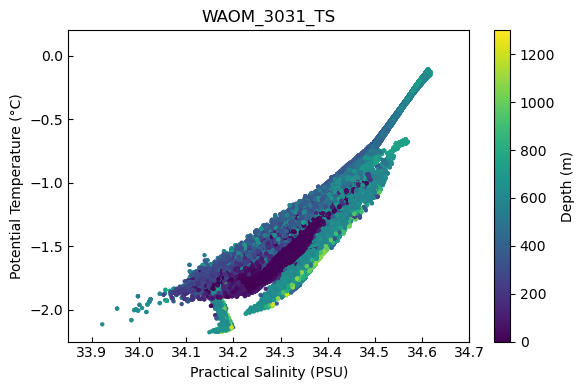

In [19]:
plt.figure(figsize=(6,4))  

scatter = plt.scatter(salinity_clean,temperature_clean,c=z_rho_clean,cmap='viridis',s=10,edgecolors='none', vmin = 0, vmax = 1300)

cbar = plt.colorbar(scatter)
cbar.set_label('Depth (m)')

plt.xlim(33.85, 34.7)
plt.ylim(-2.25, 0.2)
plt.xlabel('Practical Salinity (PSU)')
plt.ylabel('Potential Temperature (°C)')
plt.title('WAOM_3031_TS')
plt.tick_params(direction='in')
plt.tight_layout()

plt.show()


## Plotting TS data with correct pressure and NEUTRAL DENSITIES - in MATLAB

NOTES:  
If the following code does not run due to 'DLL' OSErrors, it is because python has trouble importing the 'matlab' package, when the 'rasterio' package is already imported.  
  
Simple workaround:  
 - Restart this notebook, and only run the following lines of code. Do NOT run the code above, as it interferes with the matlab import.   
  
Alternative workaround:
 - Run anaconda prompt (or terminal equivalent) as administrator
 - activate selected environment and run the following code:
 - cd "C:\Program Files\MATLAB\R2024b\extern\engines\python"
 - python setup.py install
 - OR RUN THIS:
 - cd "C:\Program Files\MATLAB\R2024b\extern\engines\python" pip install .

MATLAB NOTES:  
The following files need to be downloaded, with their paths added (eng.addpath(file_location)).  
 - https://www.teos-10.org/preteos10_software/neutral_density.html
 - https://www.teos-10.org/software.htm "GSW v3.06 MATLAB"
 - https://au.mathworks.com/matlabcentral/fileexchange/163476-ct_as_diagram_neutral_density?s_tid=FX_rc3_behav

  Note that this method uses pre-TEOS-10 software - this is because the TEOS-10 GSW Oceanographic Toolbox uses the EOS80_legacy_function.

In [1]:
import numpy as np
import matlab.engine
import matlab
import gsw

In [3]:
salinity_combined_3031 = np.load('salinity_combined_3031.npy')
temperature_combined_3031 = np.load('temperature_combined_3031.npy')
z_rho_clean_3031 = np.load('z_rho_clean_3031.npy')

In [5]:
# Notes that potential temperature and practical salinity are the inputs, the outputs are potential temp and absolute salinity
# The WAOM temp data is already in potential temp, so no conversion is needed. Thus, the matlab code in 'eng.CT_AS_diagram_neutral_density' is modified to reflect this.

T = temperature_combined_3031.flatten()         
SP = salinity_combined_3031.flatten()        

mask = np.isfinite(T) & np.isfinite(SP)
T = T[mask]
SP = SP[mask]

#######################################################################################################################################
n = len(T)
# Longitude (152.3 to 152.7° E - the centre of Cook Ice Shelf is ~ 152.5 degrees, with the ROI falling within 0.2 degrees of 152.5)
Lon = 152.3 + 0.4 * np.random.rand(n)
# Latitude (-68.3 to -68.7° S - the centre of Cook Ice Shelf is ~ -68.5 degrees, with the ROI falling within 0.2 degrees of -68.5)
Lat = -68.3 + 0.4 * np.random.rand(n)
#######################################################################################################################################

pressure_dbar = gsw.p_from_z(-np.abs(z_rho_clean_3031), -68.5) # this converts the z_rho depth in metres, at -68.5 latitude (CIS), to PRESSURE in dbar
P = pressure_dbar.flatten()
P = P[mask]
p_ref = 0 # this is the reference pressure for the isopycnals; i.e. the surface

isopycs_neutral = [27.70, 28.00, 28.27]


eng = matlab.engine.start_matlab()

# path to matlab codes:
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\eos80_legacy_gamma_n', nargout=0)
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\eos80_legacy_gamma_n\library', nargout=0)
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\gsw_matlab_v3_06_16', nargout=0)
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\gsw_matlab_v3_06_16\library', nargout=0)
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\gsw_matlab_v3_06_16\thermodynamics_from_t', nargout=0)
eng.addpath(r'C:\Users\jjls0\OneDrive\Documents\HONOURS\PROGRAMS\zOTHER DATASETS\Calculation - modes of melt\naomikrauzig-CT_AS_diagram_neutral_density-e1477db', nargout=0)

P_mat = matlab.double([[float(x)] for x in P])
SP_mat = matlab.double([[float(x)] for x in SP])
T_mat = matlab.double([[float(x)] for x in T]) 
Lon_mat = matlab.double([[x] for x in Lon])
Lat_mat = matlab.double([[x] for x in Lat])

p_ref_mat = float(p_ref)  
isopycs_neutral_mat = matlab.double(isopycs_neutral) 

SA, CT = eng.CT_AS_diagram_neutral_density(
    P_mat,
    SP_mat,
    T_mat, 
    Lon_mat,
    Lat_mat,
    p_ref_mat,
    isopycs_neutral_mat,
    nargout=2
)

SA_np = np.array(SA)
CT_np = np.array(CT)

width_inch = 160 / 25.4 
height_inch = 100 / 25.4 

eng.eval(f"set(gcf, 'PaperUnits', 'inches', 'PaperPosition', [0 0 {width_inch} {height_inch}]);", nargout=0)

# To save as PNG
#eng.eval("print(gcf, 'WAOM_100KM_seaward_of_CIS_GL.png', '-dpng', '-r300');", nargout=0)

#eng.quit()

# Calculating TS using original data